# An Introduction to Geographically-Weighted Regression in Python using PySAL and Geopandas

This notebook has been adapted from Adam Dennett's tutorial, available at [An Introduction to Geographically Weighted Regression in R](https://rstudio-pubs-static.s3.amazonaws.com/44975_0342ec49f925426fa16ebcdc28210118.html)

## PySAL doesn't currently include a GWR module, but it's available from the `master` branch on Github.  

You can install it using `pip install git+git://github.com/pysal/pysal.git`

You'll also need:
- Shapely
- Statsmodels
- Patsy
- Pandas
- Matplotlib
- Jupyter
- Scipy
- Numpy

In [27]:
import shapely
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as sm
import statsmodels.api as smg
from statsmodels.stats.outliers_influence import summary_table

import pysal as ps
from pysal.contrib import gwr
from pysal.contrib.gwr.gwr import GWR
from pysal.contrib.gwr.sel_bw import Sel_BW
from pysal.contrib.glm.family import Gaussian

import numpy as np
from scipy import stats

You can skip the next two cells, they're just for slightly nicer plotting

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamamond Pro']}
  )

In [3]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\\usepackage{sfmath}'})

## Terminology Refresher

This notebook and tutorial assumes that you have a basic familiarity with the concept of regression modelling, and using ordinary least-squares (OLS) techniques.

|  endog | exog  |
|:--------|-------:|
|    **y**    |  **X**     |
|   y variable|   X variable|
|   Left-hand side (LHS)|   Right-hand side (RHS)|
|   Dependent variable|   Independent variable|
|   Regressand|   Regressors|
|   Outcome|   Design or design matrix|
|   Response variable|  Explanatory variable|

This is some London demography data from 2011, broken down by electoral ward  
We're interested in four columns:
- `GCSE` (average GCSE results)
- `absence` (percentage of school absences)
- `noqual` (percentage of people with no qualifications)
- `cars` (cars per household)

In [264]:
def boroughs(ax):
    """ we plot these all the time """
    return boroughs_gdf.to_crs({'init': 'epsg:27700'}).plot(
            ax=ax,
            linewidth=.5,
            color='#555555',
            edgecolor='w',
            alpha=.5
        )

In [80]:
df = pd.read_csv("data/LondonData.csv")

In [267]:
# borough boundaries
boroughs_gdf = gp.read_file("data/boroughs.geojson")

In [81]:
df[['GCSE', 'absence', 'noqual', 'cars']].head()

,GCSE,absence,noqual,cars
0,363.090909,0.436792,6.7,0.385861
1,335.359259,1.477417,16.4,0.547682
2,333.111570,1.454398,31.2,0.815160
3,327.013855,1.509858,28.0,0.870236
4,339.782308,1.538591,29.1,0.918062


We're going to carry out a simple ordinary least squares (OLS) fit first, to assess the influence of the factors above on GCSE results

In [6]:
fit = sm.ols(
         formula='GCSE ~ absence+noqual+cars',
         data=df
).fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GCSE   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     220.9
Date:                Sun, 30 Jul 2017   Prob (F-statistic):           1.68e-97
Time:                        13:32:56   Log-Likelihood:                -2517.1
No. Observations:                 625   AIC:                             5042.
Df Residuals:                     621   BIC:                             5060.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    361.8912      3.071    117.844      0.000     355.861     367.922
absence      -13.0082      1.870     -6.956      0.000     -16.681      -9.336
noqual        -1.1945      0.107    -11.185      0.000      -1.404      -0.985
cars          23.3550      2.147     10.876      0.000      19.138      27.572
==============================================================================
Omnibus:                      203.049   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2160.476
Skew:                          -1.121   Prob(JB):                         0.00
Kurtosis:                      11.828   Cond. No.                         132.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We've got an R-squared value of 0.516, meaning those factors account for just over 51% of the variation in GCSE results.  
Our `p` value (`Prob(JB)`) is < 0.01, so it looks like our model is significant.

In [87]:
fit.pvalues

Intercept    0.000000e+00
absence      8.923097e-12
noqual       1.375304e-26
cars         2.447734e-25
dtype: float64

In [7]:
# normalized residuals
model_norm_residuals = fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

Plotting our standardised residuals against the fitted values, no pattern is obvious, so it looks like our model is correctly specified:

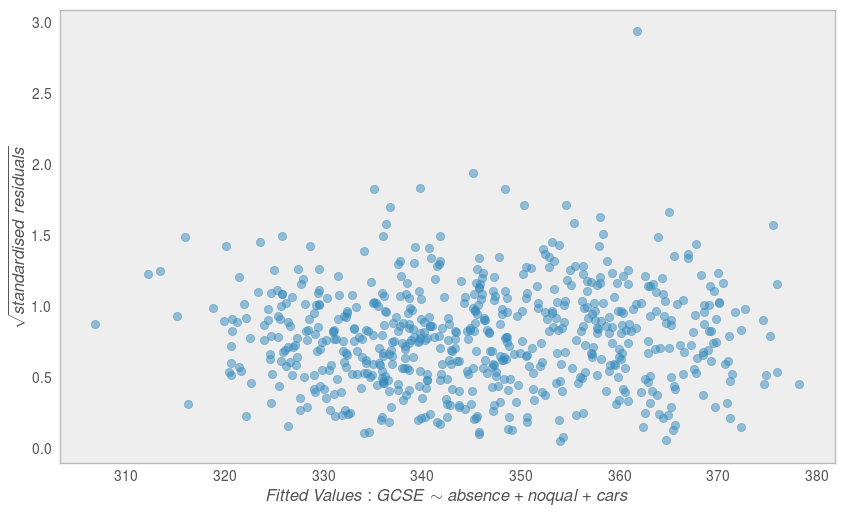

In [148]:
# This a scale-location plot, but without a line of best fit. It would be pretty much horizontal at y = 1.0, though.
plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(10., 6.),
    dpi=100,
)
sc= plt.scatter(fit.fittedvalues, model_norm_residuals_abs_sqrt, alpha=0.5)
plt.xlabel(r'$Fitted \; Values: GCSE \sim absence + noqual + cars$')
plt.ylabel(r'$\sqrt{standardised \; residuals}$')


plt.show()

Next, we're going to build a spatially-enabled DataFrame, so we can examine some of our data visually

In [89]:
# combine x and y columns into a Point geometry
df['geometry'] = df.apply(lambda row: Point(row.x, row.y), axis=1)
# convert to GeoDataFrame
gdf = gp.GeoDataFrame(df)
# add our residuals
gdf.residuals = fit.resid
# assign OSGB36 crs
gdf.crs = {'init': u'epsg:27700'}

In [90]:
# quantile the residuals
cuts = ps.Quantiles(gdf.residuals, k=4)

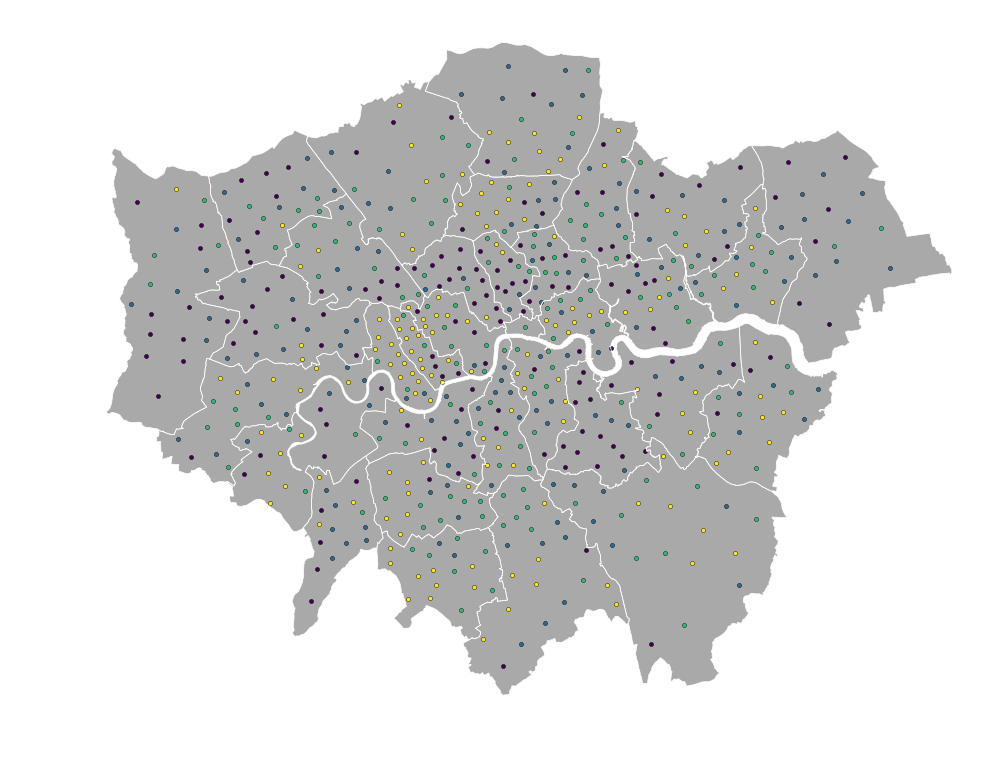

In [265]:
plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(12., 12.),
    dpi=100,
    subplot_kw=dict(aspect='equal'),
)

# temporarily assign the quantiles to a column so we can plot them 
gdf.assign(quantiles=cuts.yb).plot(
    ax=ax,
    categorical=True,
    column='quantiles',
    k=4,
    cmap='viridis',
    markeredgecolor='black',
    markersize=3.,
    markeredgewidth=0.3,
)

# impose borough boundaries
boroughs(ax)

_ = ax.axis('off')

We can see that some spatial patterning is discernible, in the form of clustered residuals in the same quartile.  
This is OK, but we'd like to make that determination analytically. We can use `PySAL` to determine whether this is actually the case. Formally, we're going to try to reject the null hypothesis:  

**"The residuals are randomly distributed in space"**

First, we need to build spatial weights from all four variables and the coordinates  
We need the `x` and `y` column values from the non-spatial DataFrame for this

In [ ]:
# repackage variables for convenience (we'll drop GCSE in the regression)
yxs = gdf.loc[:, ['GCSE','absence', 'noqual', 'cars']]

spatial_weights = ps.knnW_from_array(
    df.loc[yxs.index, ['x', 'y']].values
)

# Row-standarise the weights
spatial_weights.transform = 'R'

Now we're going to carry out the same OLS regression as above, with spatial diagnostics enabled

In [ ]:
spatial_fit = ps.spreg.OLS(
    df.GCSE.values[:, None],
    yxs.drop('GCSE', axis=1).values,
    w=spatial_weights,
    spat_diag=True,
    name_x=yxs.drop('GCSE', axis=1).columns.tolist(),
    name_y='ln(GCSE)'
)

In [15]:
print(spatial_fit.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    ln(GCSE)                Number of Observations:         625
Mean dependent var  :    345.8406                Number of Variables   :           4
S.D. dependent var  :     19.5388                Degrees of Freedom    :         621
R-squared           :      0.5163
Adjusted R-squared  :      0.5139
Sum squared residual:  115234.766                F-statistic           :    220.9246
Sigma-square        :     185.563                Prob(F-statistic)     :    1.68e-97
S.E. of regression  :      13.622                Log likelihood        :   -2517.141
Sigma-square ML     :     184.376                Akaike info criterion :    5042.283
S.E of regression ML:     13.5785                Schwarz criterion     :    5060.034

-----------------------------------------------------------------------------

The spatial dependence diagnostics show clear evidence to reject the null hypothesis:  
**"The residuals are randomly distributed in space"**  

The results of the Koenker-Bassett test for non-stationarity are also significant: small p-values (< 0.05) indicate statistically significant regional variation  

It should be noted that a key assumption of OLS is that error terms are independently distributed. Data that cause us to reject this assumption – such as those above – justify a spatial approach (i.e. a geographically-weighted regression).  

See more [here](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) and [Anselin and Rey (2015)](https://books.google.co.uk/books/about/Modern_Spatial_Econometrics_in_Practice.html)

### Geographically-Weighted Regression
GWR provides a local model of the variable or process you are trying to understand / predict by fitting a regression equation to **every feature in the dataset**.  
GWR constructs these separate equations by incorporating the dependent and explanatory variables of features **falling within the bandwidth of each target feature**.  
The shape and size of the bandwidth is dependent on user input for the following parameters:
- kernel type
- bandwidth method
- distance or number of neighbours

The **kernel** refers to a window function. That is, a mathematical function that is zero-valued outside some specified interval. Rather than using a constant window, which would have a fixed value inside and zero value outside, a function generating a smooth curve is generally used.  
Both Gaussian and Bi-square kernels incorporate a distance-decay function which allocates more weight to properties closer to a regression point than properties located further away. See the figure below.

The `fixed` keyword below indicate whether the kernel is always fixed, or if it's allowed to vary in extent **as a function of feature density**:

- `True`: the spatial context (the kernel, be it gaussian, bisquare or other) used to solve each local regression analysis is **a fixed distance**
- `False`: the spatial context is a function of a **specified number of neighbors**. Where feature distribution is dense, the spatial context is smaller; where feature distribution is sparse, the spatial context is larger.

Thus, when when we discuss bandwidth in the context of GWR, we're referring **either** to distance **or** number of neighbours

![title](data/kernel_bandwidth.png)

For further discussion of the effects of kernel and bandwidth selection, see:   
[*The effect of kernel and bandwidth specification in geographically weighted regression models on the accuracy and uniformity of mass real estate appraisal*](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=uHq8nmsAAAAJ&citation_for_view=uHq8nmsAAAAJ:2osOgNQ5qMEC)  
PE Bidanset, JR Lombard - Journal of Property Tax Assessment & Administration, 2014

In [199]:
# arrange endog (y) as a column vector, i.e. an m x 1 array
endog = df.GCSE.values.reshape(-1, 1)
# exog (X) is an m x n array, where m is the number of rows, and n is the number of regressors
exog = df[['absence', 'noqual', 'cars']].values

# Python 3 zip returns an iterable
coords = list(zip(df.x.values, df.y.values))

In [238]:
# Instantiate bandwidth selection class - bisquare NN (adaptive)
bw = Sel_BW(
    coords,
    endog,
    exog,
    kernel='bisquare', fixed=False
)

### Bandwidth Selection

The `criterion` keyword specifies how the extent of the kernel should be determined. We're using the Akaike Information Criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)), corrected for sample sizes. Others are available:

- `'AIC'` (Akaike, non-corrected)
- `'CV'` (Cross-validation)
- `'BIC'` ([Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion))

An explanation of when you should choose one of these over the other is beyond the scope of this notebook, but [this](https://stats.stackexchange.com/a/767) is a concise explanation of the different approaches. See also [here](https://stats.stackexchange.com/a/20738).

It's also possible to specify minimum and maximum bandwidths using the `bw_min` and `bw_max` keywords

In [239]:
# Find optimal bandwidth by minimizing AICc using golden section search algorithm
bw = bw.search(
    search='golden_section',
    criterion='AICc',
#     bw_min=10,
#     bw_max=500
)
print(bw)

89.0


### Running the Model
- `family`: specifies the underlying probability model  
- `kernel`: the type of kernel function used to weight observations. `gaussian`, `bisquare`, and `exponential` kernels can be selected
- `fixed`: see [above](#Geographically-Weighted-Regression).

In [261]:
# Instantiate GWR model and estimate parameters and diagnostics
model = GWR(
    coords,
    endog,
    exog,
    89.,
    family=Gaussian(),
    fixed=False,
    kernel='gaussian')

results = model.fit()

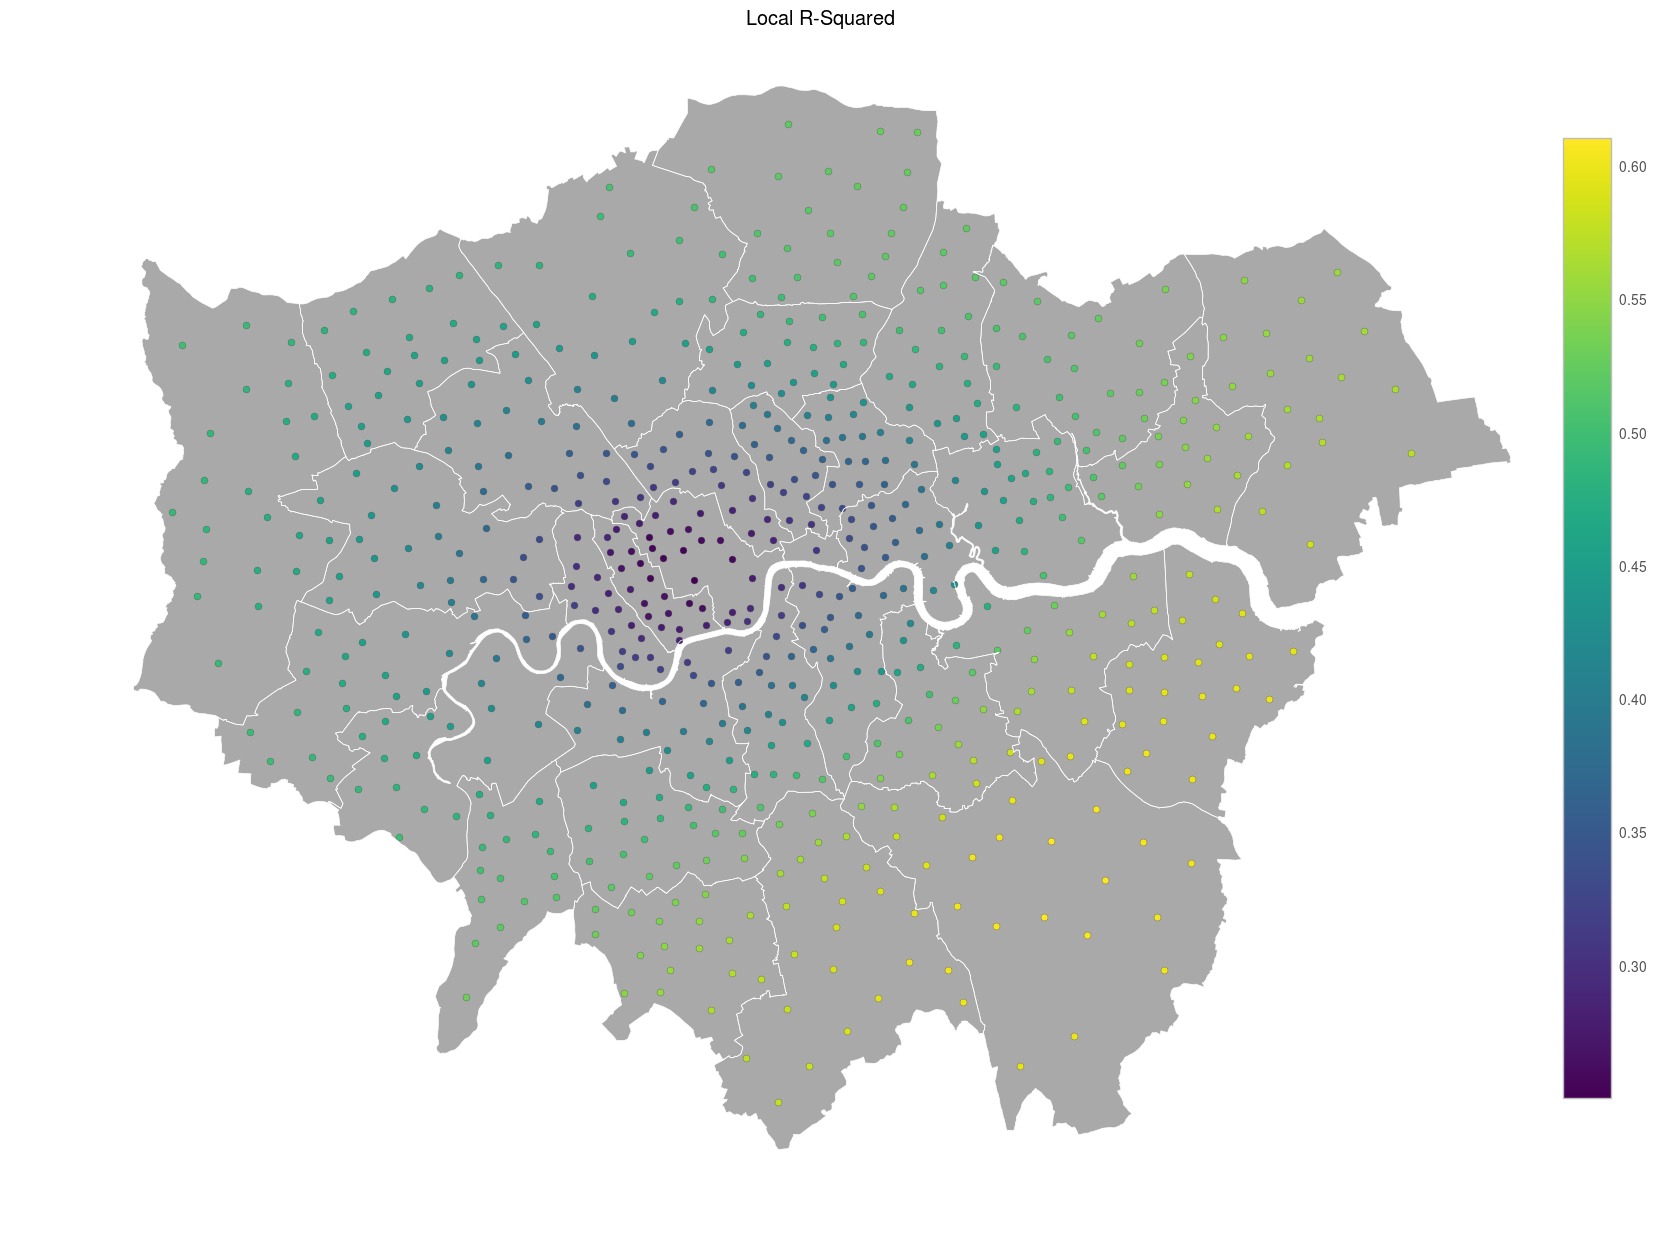

In [262]:
# Map local R-square values (a weighted R-square at each observation location)

plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(16., 16.),
    dpi=100,
    subplot_kw=dict(aspect='equal'),
)

# add local R2 to df
gdf['localR2'] = results.localR2
vmin, vmax = np.min(gdf['localR2']), np.max(gdf['localR2']) 
gdf.plot(
    'localR2',
    markersize=5.,
    markeredgecolor='#555555',
    markeredgewidth=.25,
    vmin=vmin,
    vmax=vmax,
    cmap='viridis',
    ax=ax
)

# impose borough boundaries
boroughs(ax)

ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([0.98, 0.2, 0.03, 0.6])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')
sm._A = []
fig.colorbar(sm, cax=cax)
_ = ax.axis('off')

plt.tight_layout()
plt.show()

From the plot above, we can see that our model is performing poorly (well below the baseline ~51% we would expect) in one particular area. 

## Let's map each of the coefficient estimates
Reminder: Regression coefficients (β) are values – one for each explanatory variable – that represent the **strength and type** (positive or negative) of the relationship the explanatory variable has to the dependent variable.  

Since we're interested in positive, negative, or neutral correlations, it's important to select a diverging colour scale here, which represents midpoint values as neutral.

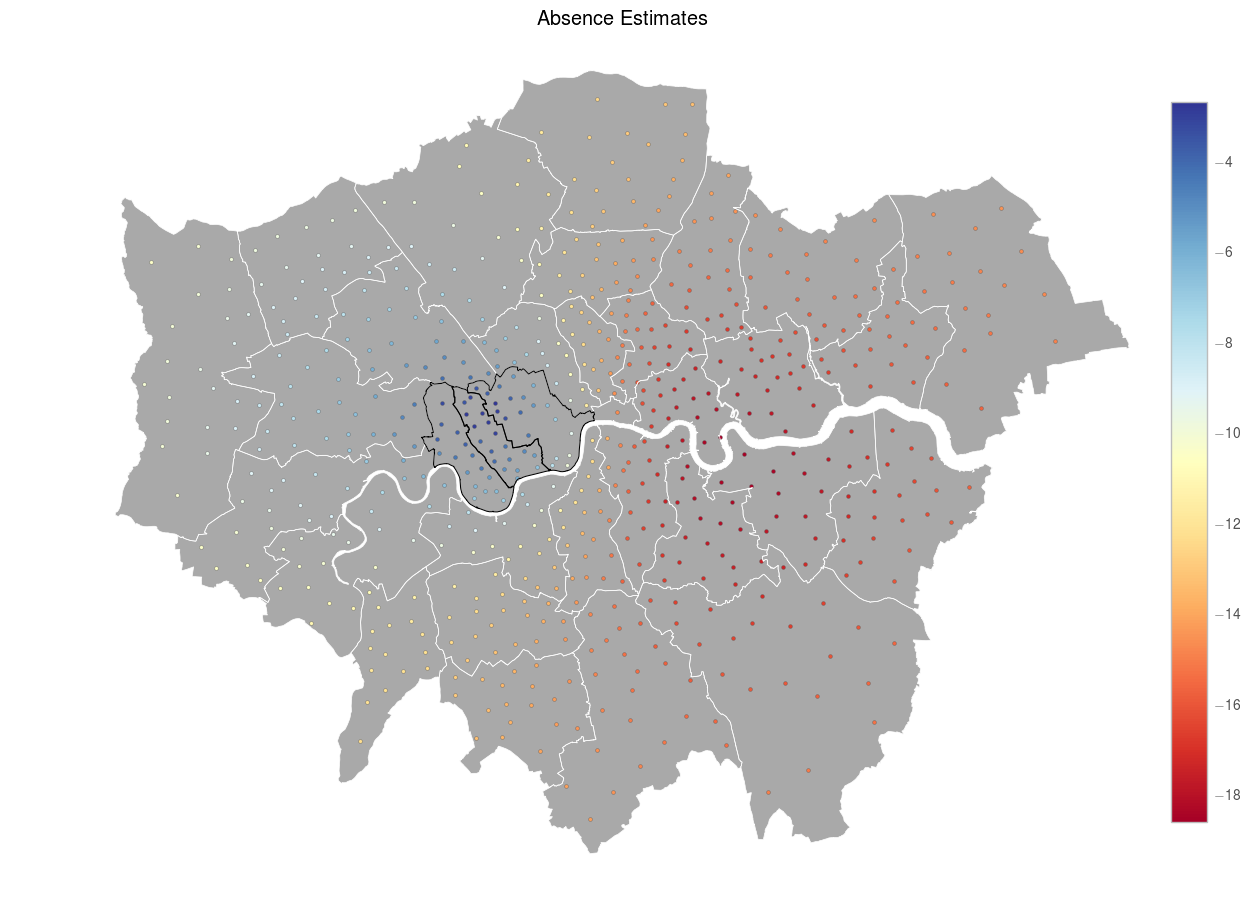

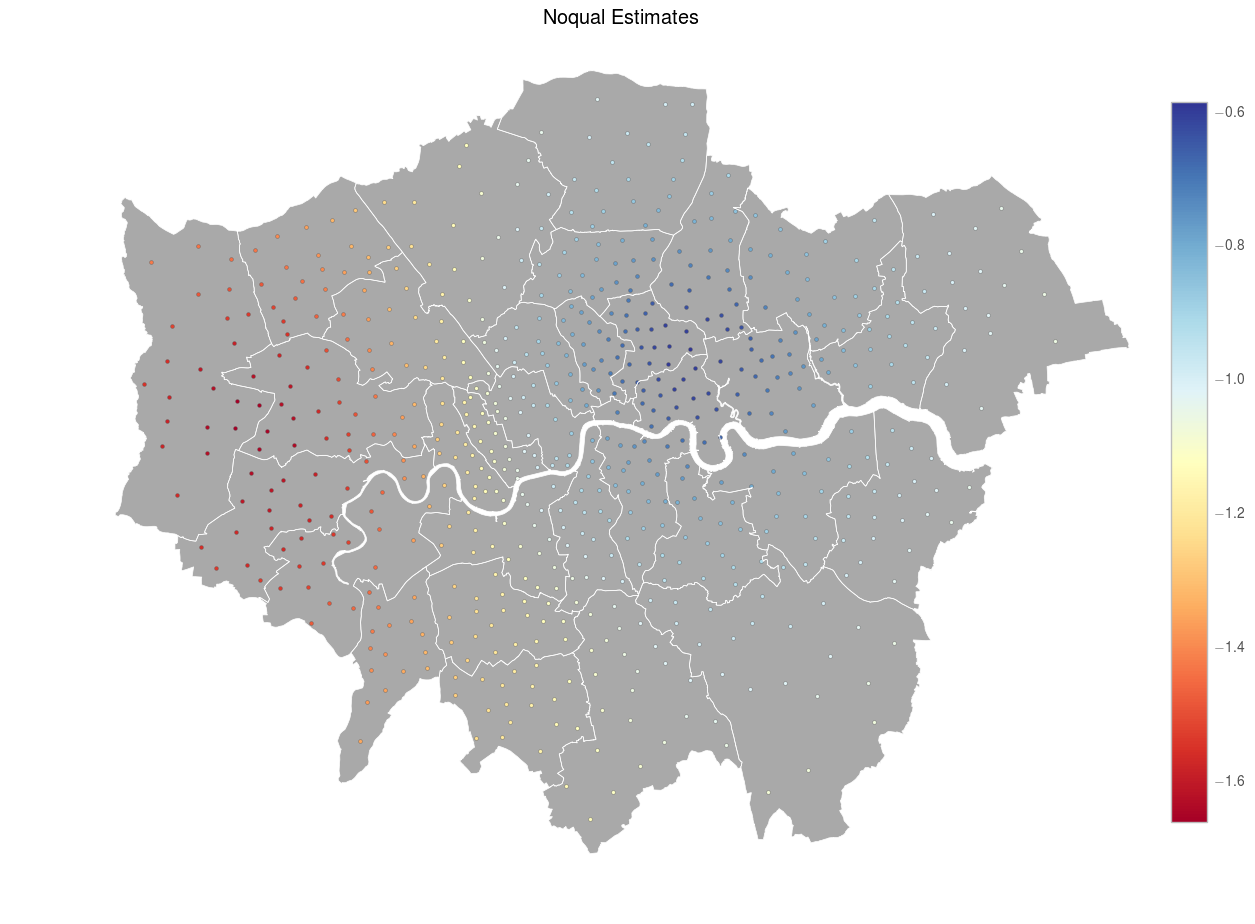

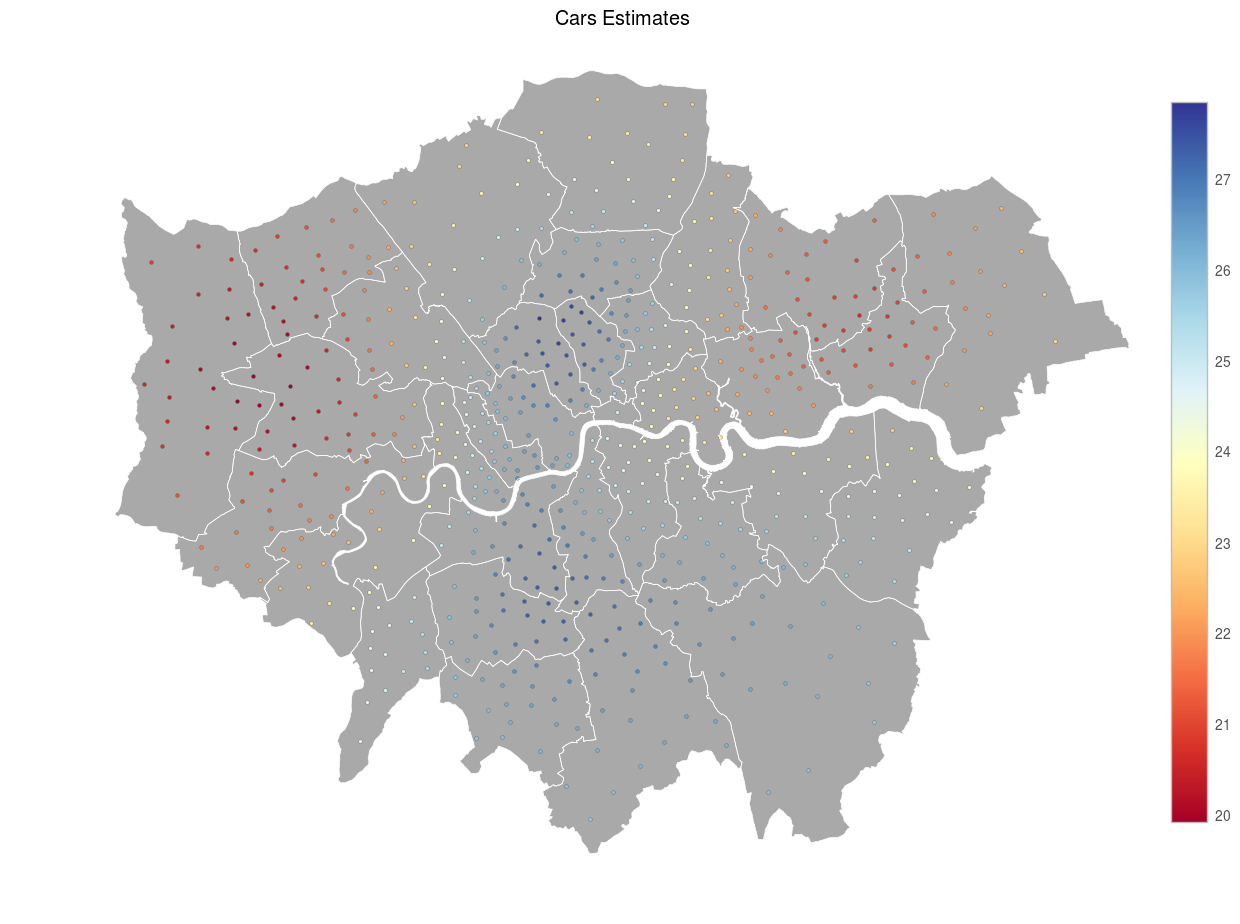

In [263]:
labels = ['Intercept', 'Absence', 'Noqual', 'Cars']
boroughs = ['Westminster', 'Kensington and Chelsea', 'Hammersmith and Fulham']

# Map Parameter estimates for each covariate
# we're skipping the intercept, hence range(1, ...)
for param in range(1, results.params.shape[1]):
    plt.clf()
    fig, ax = plt.subplots(
        1,
        figsize=(12., 12.),
        dpi=100,
        subplot_kw=dict(aspect='equal'),
    )
    gdf[str(param)] = results.params[:, param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    gdf.plot(
        str(param),
        markersize=2.75,
        markeredgecolor='#555555',
        markeredgewidth=.25,
        vmin=vmin,
        vmax=vmax,
        cmap='RdYlBu',
        ax=ax
    )
    
    # impose borough boundaries
    boroughs(ax)

    # outline the boroughs with high positive "Absence" correlation
    if param == 1:
        # display boroughs with most AirBnB
        top = boroughs_gdf.to_crs({'init': 'epsg:27700'}).loc[boroughs_gdf['neighbourhood'].isin(boroughs)].plot(
            ax=ax,
            linewidth=.75,
            color='None',
            edgecolor='k'
        )

    ax.set_title(labels[param] + ' Estimates')
    cfig = ax.get_figure()
    cax = cfig.add_axes([0.98, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='RdYlBu')
    sm._A = []
    cfig.colorbar(sm, cax=cax)
    _ = ax.axis('off')
    
    plt.tight_layout()
    plt.show()

### Looking at the "Absence" coefficient plot, we can see that for the majority of boroughs in London, there's a negative relationship: as unauthorised absence goes up, exam scores go down. This is what one would expect.

>However, for three boroughs (Westminster, Kensington & Chelsea and Hammersmith and Fulham - the richest in London, outlined in black), the relationship is positive: as unauthorised school absence increases, so does average GCSE score.
This is a highly counterintuitive pattern, but may partly be explained by the multiple homes owned by many living in these boroughs (students living in different parts of the country and indeed the world for significant periods of the year) and the over-representation of private schooling of those living in these areas.
If this isn't the case, and unauthorised absence from school is reflecting the unauthorised absence of poorer students attending local, inner-city schools, then high GCSE grades may also reflect the achievements of those who are sent away to expensive fee-paying schools elsewhere in the country and who return to their parental homes later in the year.

Adapted from [Dennett, 2014](https://rstudio-pubs-static.s3.amazonaws.com/44975_0342ec49f925426fa16ebcdc28210118.html)

#### Further Steps
Reducing the bandwidth – by selecting a gaussian rather than a bisquare kernel – from 89 to 49 reduces the positive correlation between absences (fitting with a bisquare kernel) and results in the three boroughs in question significantly, from around 20 to 5.

Maintaining the bandwidth around 89 by using a bisquare kernel, but carrying out the regression using a gaussian kernel **increases the local $R^2$ to around .25 from .1**, and **eliminates the positive correlation entirely**.



Other resources, from Esri:

http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/how-gwr-regression-works.htm
http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/geographically-weighted-regression.htm
http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-statistics-toolbox/interpreting-gwr-results.htm